# Часть 1. Предварительная обработка и аннотирование

### 1.1 Импорт библиотек

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Embedding, RepeatVector, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Concatenate
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from lxml import etree
from sklearn.model_selection import train_test_split
import pickle
from datetime import datetime
import xml.etree.ElementTree as ET
from pylatexenc.latexwalker import LatexWalker, LatexMacroNode, LatexCharsNode, LatexEnvironmentNode

### 1.2 Выбор размера изображения и функция препроцессинга изображений

In [3]:
# Желаемый размер изображений
desired_width = 256
desired_height = 256

# Функция для загрузки и предобработки изображений
def load_and_preprocess_images(folder, width, height):
    def preprocess_image(img, width, height):
        # Сглаживание изображения
        img = cv2.GaussianBlur(img, (5, 5), 0)
        # Адаптивное пороговое значение
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        # Изменение размера изображения
        img = cv2.resize(img, (width, height))
        return img

    images = {}
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = preprocess_image(img, width, height)
                images[os.path.splitext(filename)[0]] = img
            else:
                print(f"Failed to read image: {filename}")
    return images

### 1.3 Функция паринга InkML файлов для получения формул latex из папки с аннотациями

In [4]:
# Функция для парсинга InkML файлов и извлечения LaTeX-аннотаций
def parse_inkml(file_path):
    try:
        tree = etree.parse(file_path, etree.XMLParser(recover=True))
        root = tree.getroot()
        namespace = {'ink': 'http://www.w3.org/2003/InkML'}
        
        # Извлечение всех аннотаций LaTeX
        latex_expressions = []
        for annotation in root.findall('.//ink:annotation', namespaces=namespace):
            if annotation.attrib.get('type') == 'truth':
                latex_expressions.append(annotation.text)
        if not latex_expressions:
            print(f"No LaTeX annotations found in {file_path}")
        return latex_expressions
    except etree.XMLSyntaxError as e:
        print(f"Error parsing {file_path}: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error parsing {file_path}: {e}")
        return None
    
# Функция для загрузки аннотаций из всех InkML файлов в папке
def load_annotations(folder):
    annotations = {}
    for filename in os.listdir(folder):
        if filename.endswith('.inkml'):
            file_path = os.path.join(folder, filename)
            latex_expressions = parse_inkml(file_path)
            if latex_expressions:
                annotations[os.path.splitext(filename)[0]] = latex_expressions[0]
    return annotations

### 1.4 Пути к папкам изображений и inkml аннотаций, и запуск загрузки данных

In [5]:
# Пути к папкам с изображениями и аннотациями
images_folder_train = './data_2019/1_images_train'
annotations_folder_train = './data_2019/2_annotation_train'
images_folder_test = './data_2019/3_images_test'
annotations_folder_test = './data_2019/4_annotation_test'

# Загрузка изображений и аннотаций для тренировочных данных
images_train = load_and_preprocess_images(images_folder_train, desired_width, desired_height)
print(f"Loaded {len(images_train)} training images")

annotations_train = load_annotations(annotations_folder_train)
print(f"Loaded {len(annotations_train)} training annotations")

# Загрузка изображений и аннотаций для тестовых данных
images_test = load_and_preprocess_images(images_folder_test, desired_width, desired_height)
print(f"Loaded {len(images_test)} testing images")

annotations_test = load_annotations(annotations_folder_test)
print(f"Loaded {len(annotations_test)} testing annotations")

Loaded 10979 training images
Loaded 10979 training annotations
Loaded 1199 testing images
Loaded 1199 testing annotations


### 1.5 Создание пары [изображение; аннотация] по ключу (в качестве ключа выступают имена файлов)

In [6]:
# Объединение изображений и аннотаций для тренировочных данных
data_train = []
for key in images_train:
    if key in annotations_train:
        data_train.append((images_train[key], annotations_train[key]))

# Объединение изображений и аннотаций для тестовых данных
data_test = []
for key in images_test:
    if key in annotations_test:
        data_test.append((images_test[key], annotations_test[key]))

### 1.6 Выведем 5 экземпляров latex аннотаций для проверки

In [7]:
# Пример вывода данных
print("Training Data:")
for image, annotation in data_train[:5]:  # Вывод первых 5 экземпляров 
    print(f"Image Shape: {image.shape}, Annotation: {annotation}")

print("\nTesting Data:")
for image, annotation in data_test[:5]:  # Вывод первых 5 экземпляров
    print(f"Image Shape: {image.shape}, Annotation: {annotation}")

Training Data:
Image Shape: (256, 256), Annotation:   $y = Ax + A^2$
Image Shape: (256, 256), Annotation:   $B_n(1-x)=(-1)^n B_n(x)$
Image Shape: (256, 256), Annotation: $0 < x < 1$
Image Shape: (256, 256), Annotation: $A ( B + C ) = A B + A C$
Image Shape: (256, 256), Annotation: $A\times B$

Testing Data:
Image Shape: (256, 256), Annotation: $-\frac{1}{192}$
Image Shape: (256, 256), Annotation: $x^{\prime} = (ax+b)(cx+d)^{-1}$
Image Shape: (256, 256), Annotation: $z(\log z)^n$
Image Shape: (256, 256), Annotation: $x_1^2 + x_2^2 + x_3^2 = 1$
Image Shape: (256, 256), Annotation: $\sqrt{x^2}$


### 1.7 Выведем первые 5 пар [изображение; аннотация] для наглядности

Training Data:


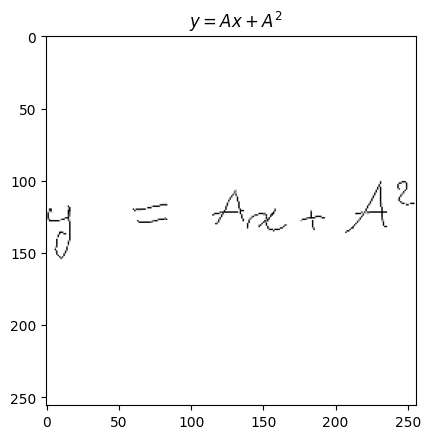

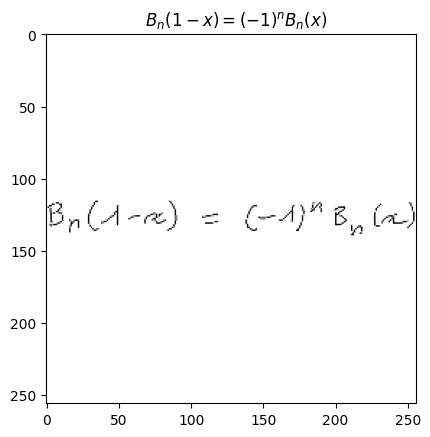

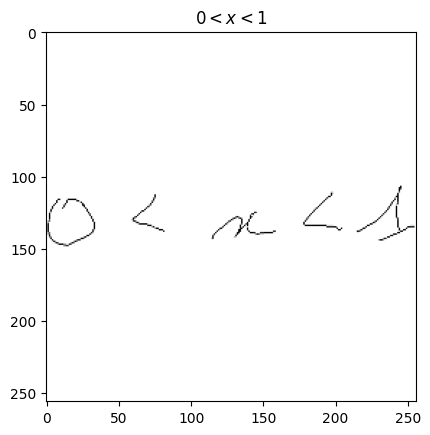

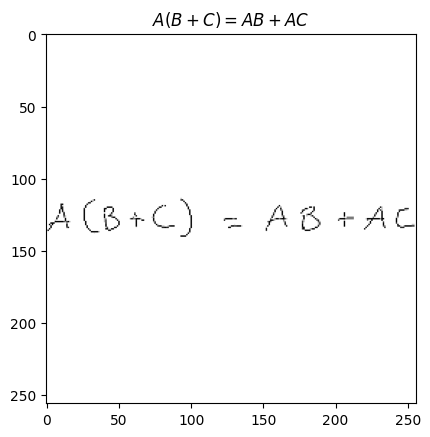

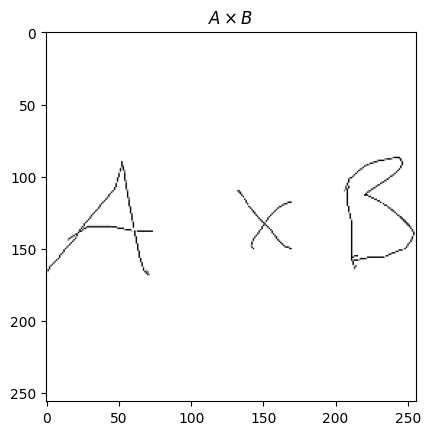

Testing Data:


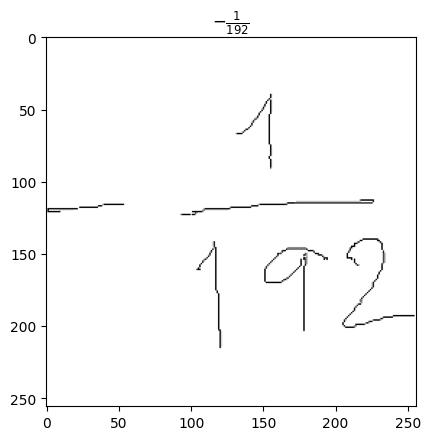

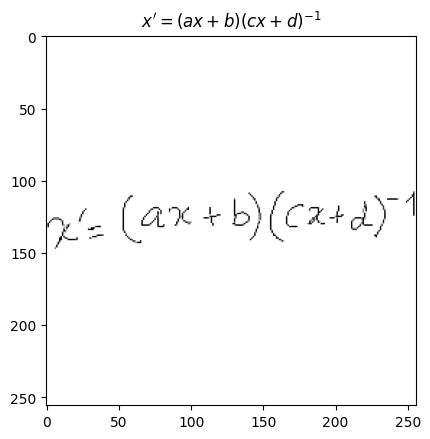

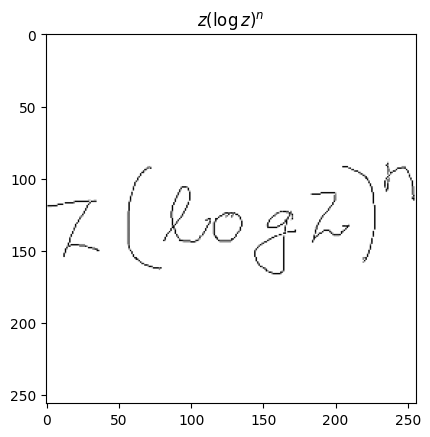

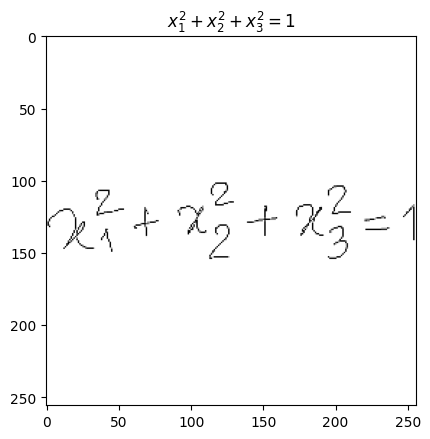

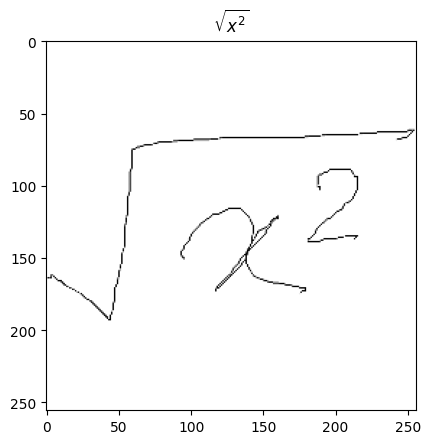

In [10]:
# Вывод первых 5 пар изображение-аннотация для проверки тренировочных данных

print("Training Data:")
for i in range(min(5, len(data_train))):
    img, annotation = data_train[i]
    plt.imshow(img, cmap='gray')
    plt.title(annotation)
    plt.show()

# Вывод первых 5 пар изображение-аннотация для проверки тестовых данных
print("Testing Data:")
for i in range(min(5, len(data_test))):  
    img, annotation = data_test[i]
    plt.imshow(img, cmap='gray')
    plt.title(annotation)
    plt.show()

### 1.8 Объединяем данные в массивы NumPy и масштабируем значение пикселей в диапазон [0; 1] принтим количество данных

In [11]:
# Определение ожидаемой формы изображений
img_shape = data_train[0][0].shape

# Преобразование изображений и аннотаций в массивы numpy для тренировочных данных
X_train = np.stack([x[0] for x in data_train])
y_train = [x[1] for x in data_train]

# Преобразование изображений и аннотаций в массивы numpy для тестовых данных
X_test = np.stack([x[0] for x in data_test])
y_test = [x[1] for x in data_test]

# Масштабирование значений пикселей до диапазона [0, 1] и преобразование в float16
X_train = X_train.astype('float16') / 255.0
X_test = X_test.astype('float16') / 255.0

# Проверка размеров массивов
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", len(y_train))
print("y_test shape:", len(y_test))

X_train shape: (10979, 256, 256)
X_test shape: (1199, 256, 256)
y_train shape: 10979
y_test shape: 1199


# Часть 2. Создание словаря токеайзера и подготовка самого токенайзера

### 2.1 Первую очередь приравняем тренировочные данные в качестве примера для проверки адекватности работы токенайзера

In [15]:
# Пример аннотированных LaTeX формул
latex_examples = y_train

# Создаем базовый словарь LaTeX символов и операторов
latex_tokens2 = [
    '\\frac', '\\right', '\\left', '\\sqrt', '\\mbox', '_', '\\int', '\\sin', ')', 
    '\\sum', '^', '(', '\\log', '\\lim', '\\alpha', '\\times', '\\pi', '\\beta', 
    '\\cos', '[', ']', '+', '-', '=', '\\leq', '\\geq', '\\cdot', '\\neq', 
    '\\infty', '\\partial', '\\forall', '\\exists', '\\neg', '\\lor', '\\land', 
    '\\rightarrow', '\\leftarrow', '\\uparrow', '\\downarrow', '\\circ', '\\bullet', 
    '\\perp', '\\parallel', '\\oplus', '\\otimes', '\\approx', '\\sim', '\\cong', 
    '\\equiv', '\\propto', '\\subset', '\\supset', '\\subseteq', '\\supseteq', 
    '\\cup', '\\cap', '\\setminus', '\\vdash', '\\dashv', '\\models', '\\mid', 
    '\\parallel', '\\perp', '\\simeq', '\\asymp', '\\doteq', '\\bowtie', '\\lt', 
    '\\gt', '\\prime', '\\star', '\\dagger', '\\ddagger', '\\angle', '\\measuredangle', 
    '\\triangle', '\\square', '\\diamond', '\\lozenge', '\\blacktriangle', 
    '\\blacktriangledown', '\\blacksquare', '\\blacklozenge', '\\in', '\\notin', 
    '\\ni', '\\owns', '\\to', '\\mapsto', '\\longrightarrow', '\\longmapsto', 
    '\\leftarrow', '\\hookrightarrow', '\\leftrightarrow', '\\iff', '\\implies', 
    '\\subsetneq', '\\supsetneq', '\\vdots', '\\ddots', '\\aleph', '\\beth', 
    '\\gimel', '\\daleth', '\\hbar', '\\imath', '\\jmath', '\\ell', '\\wp', 
    '\\Re', '\\Im', '\\top', '\\bot', '\\emptyset', '\\nabla', '\\surd', 
    '\\triangleleft', '\\triangleright', '\\Box', '\\Diamond', '\\vee', '\\wedge', 
    '\\lfloor', '\\rfloor', '\\lceil', '\\rceil', '\\langle', '\\rangle', 
    '\\Vert', '\\vert', '\\}', '\\{', '\\$', '\\%', '\\&', '\\_', '\\#', 
    '\\text{', '\\mathbf{', '\\mathbb{', '\\mathcal{', '\\mathfrak{', '\\mathsf{', 
    '\\mathtt{', '\\textit{', '\\textrm{', '\\textbf{', '\\textsf{', '\\texttt{', '\\lesssim', '\\gtrsim',
    '\\lessapprox', '\\gtrapprox', '\\mathbb{Z}', '\\mathbb{Q}', '\\mathbb{R}', '\\mathbb{C}', '\\overline', 
    '\\blacksquare', '\\blacksquare', '\\mathbb{S}', '\\vert', '\\Vert', ',' , '$', 
    '<', '>', '=', '\\leq', '\\geq', '\\ll', '\\gg', '\\prec', '\\succ', '\\sim', '\\approx', 
    '\\cong', '\\simeq', '\\asymp', '\\doteq', '\\equiv', '\\subset', '\\supset', '\\subseteq', 
    '\\supseteq', '\\sqsubset', '\\sqsupset', '\\sqsubseteq', '\\sqsupseteq', '\\in', 
    '\\ni', '\\notin', '\\propto', '\\parallel', '\\perp', '{', '}', '\\{', '}\\' ,
    '\\Bigg','\\ldots', '.' , '/', '\\mathrm' , '|', '\\tan', '\\pm', '\\Big', '\\cdots', '!' , 
    '\\limits', '\\div', '\'', '\\', '\\gt', ';', '\\lt', '\\rbrack', '\\lbrack', '\\dots', '\\Pi', '\\hbox', '\\vtop'
]

# Добавляем цифры, латинские и греческие буквы
digits = list('0123456789')
latin_lowercase = list('abcdefghijklmnopqrstuvwxyz')
latin_uppercase = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
greek_letters = ['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 
                 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 
                 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega']
greek_letters2 = ['gamma', 'delta', 'theta', 'lambda', 'xi', 'phi', 'psi', 'omega']
greek_lowercase = [f'\\{letter}' for letter in greek_letters]
greek_uppercase = [f'\\{letter.capitalize()}' for letter in greek_letters2]

#Более простой словарь который подходит под данные CROHME 2019
simple_latex = ["\\parallel", "\\alpha", "\\pi", "\\beta", "=", "\\leq", "\\geq", "\\lt", "\\gt", "\\in", "\\frac", "\\right", "\\left", 
"\\sqrt", "\\mbox", "_", "\\int", "\\sin", ")", "\\sum", "^", "(", "\\log", "\\lim", "\\times", "\\cos", "[", "]", "+", "-", 
"\\cdot", "\\neq", "\\infty", "\\forall", "\\exists", "\\rightarrow", "\\prime", "\\to", ",", "$", "<", ">", "{", "}", 
"\\Bigg", "\\ldots", ".", "/", "\\mathrm", "|", "\\tan", "\\pm", "\\Big", "\\cdots", "!", "\\limits", "\\div", "'", 
"\\", ";", "\\rbrack", "\\lbrack", "\\dots", "\\Pi", "\\hbox", "\\vtop", "0", "1", "2", "3", "4", "5", "6", "7", 
"8", "9", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", 
 "u", "v", "w", "x", "y", "z", "A", "B", "C", "E", "F", "G", "H", "I", "L", "M", "N", "O", "P", "R", "S", "T", 
 "V", "W", "X", "Y", "\\gamma", "\\theta", "\\lambda", "\\mu", "\\sigma", "\\phi", "\\Delta" ]

# Объединяем все latex документы в единый словарь и выводим его на экран
latex_tokens = simple_latex
print(latex_tokens)
print('Length of vocabular:', len(latex_tokens))

['\\parallel', '\\alpha', '\\pi', '\\beta', '=', '\\leq', '\\geq', '\\lt', '\\gt', '\\in', '\\frac', '\\right', '\\left', '\\sqrt', '\\mbox', '_', '\\int', '\\sin', ')', '\\sum', '^', '(', '\\log', '\\lim', '\\times', '\\cos', '[', ']', '+', '-', '\\cdot', '\\neq', '\\infty', '\\forall', '\\exists', '\\rightarrow', '\\prime', '\\to', ',', '$', '<', '>', '{', '}', '\\Bigg', '\\ldots', '.', '/', '\\mathrm', '|', '\\tan', '\\pm', '\\Big', '\\cdots', '!', '\\limits', '\\div', "'", '\\', ';', '\\rbrack', '\\lbrack', '\\dots', '\\Pi', '\\hbox', '\\vtop', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', '\\gamma', '\\theta', '\\lambda', '\\mu', '\\sigma', '\\phi', '\\Delta']
Length of vocabular: 129


### 2.2 В качестве базовых алгоритмов нужен токенайзер из библиотеки tensorflow но он изначально заточен для работы с простым текстом, нам надо его настроить так чтобы он работал с latex словарем

In [16]:
# Создаем токенизатор
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(latex_tokens)


# Функция для токенизации LaTeX формулы
def custom_latex_tokenizer(formula):
    tokens = re.findall(r'\\[a-zA-Z]+|[a-zA-Z0-9]|[^\s]', formula)
    return tokens

# Определяем количество классов
num_classes = len(tokenizer.word_index) + 1  # +1 для учета индекса 0

### 2.3 Применение токенизатора ко всем аннотациям в датасете, поготовка токенеированных данных для обучения нейросети

In [17]:
# Применение токенизатора ко всем примерам
tokenized_examples = [custom_latex_tokenizer(formula) for formula in latex_examples]

# Преобразование текстов в числовые последовательности
encoded_examples = tokenizer.texts_to_sequences(tokenized_examples)

# Приведение последовательностей к одинаковой длине
max_length = max(len(seq) for seq in encoded_examples)
padded_examples = pad_sequences(encoded_examples, padding='post', maxlen=max_length)

# Обратное преобразование числовых последовательностей в текст
reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
decoded_examples = [[reverse_word_index.get(index, '') for index in sequence] for sequence in padded_examples]

# Определение максимальной длины последовательности
max_length = max(len(seq) for seq in encoded_examples)

### 2.4 Сохранение токенизатора и запись словаря токенов в файл для проверки полноты

In [18]:
# Сохранение токенизатора
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Запись словаря токенов в файл
with open('latex_token.txt', 'w') as f:
    for word, index in tokenizer.word_index.items():
        f.write(f"{word}: {index}\n")

### 2.5 Выведем 3 сущности:  1. Оригинальные latex аннотоации;  2. Токенезированные;  3. Закодированные в числовые метки;

In [19]:
# Печать закодированных последовательностей
print("Tokenized and Encoded Sequences:")
for original, tokenized, encoded in zip(latex_examples, tokenized_examples, encoded_examples):
    print(f"Original: {original}")
    print(f"Tokenized: {tokenized}")
    print(f"Encoded: {encoded}")

Tokenized and Encoded Sequences:
Original:   $y = Ax + A^2$
Tokenized: ['$', 'y', '=', 'A', 'x', '+', 'A', '^', '2', '$']
Encoded: [40, 101, 5, 103, 100, 29, 103, 21, 69, 40]
Original:   $B_n(1-x)=(-1)^n B_n(x)$
Tokenized: ['$', 'B', '_', 'n', '(', '1', '-', 'x', ')', '=', '(', '-', '1', ')', '^', 'n', 'B', '_', 'n', '(', 'x', ')', '$']
Encoded: [40, 104, 16, 90, 22, 68, 30, 100, 19, 5, 22, 30, 68, 19, 21, 90, 104, 16, 90, 22, 100, 19, 40]
Original: $0 < x < 1$
Tokenized: ['$', '0', '<', 'x', '<', '1', '$']
Encoded: [40, 67, 41, 100, 41, 68, 40]
Original: $A ( B + C ) = A B + A C$
Tokenized: ['$', 'A', '(', 'B', '+', 'C', ')', '=', 'A', 'B', '+', 'A', 'C', '$']
Encoded: [40, 103, 22, 104, 29, 105, 19, 5, 103, 104, 29, 103, 105, 40]
Original: $A\times B$
Tokenized: ['$', 'A', '\\times', 'B', '$']
Encoded: [40, 103, 25, 104, 40]
Original: $A_2>B_2$
Tokenized: ['$', 'A', '_', '2', '>', 'B', '_', '2', '$']
Encoded: [40, 103, 16, 69, 42, 104, 16, 69, 40]
Original:   $\forall x \in A, \foral

### 2.6 Проверка токенезированных формул методом обратной токенизации

In [23]:
# Печать декодированных последовательностей
with open('check_latex_decoded.txt', 'w') as f:
    print("\nDecoded Sequences:")
    for decoded in decoded_examples:
        print(' '.join(decoded))
        f.write(''.join(decoded)+'\n')

# 1. Создаем пустой массив
data_array = []

# 2. Читаем текстовый файл "check_latex_decoded.txt"
with open("check_latex_decoded.txt", "r", encoding="utf-8") as file:
    content = file.read()

# 3. Разделяем содержимое по символу новой строки и добавляем в массив
data_array = content.split('\n')

# Выводим результат
for i, line in enumerate(data_array):
    print(f"Line {i+1}: {line}")


Decoded Sequences:
$ y = A x + A ^ 2 $                                                                                                                                                                                                    
$ B _ n ( 1 - x ) = ( - 1 ) ^ n B _ n ( x ) $                                                                                                                                                                                       
$ 0 < x < 1 $                                                                                                                                                                                                       
$ A ( B + C ) = A B + A C $                                                                                                                                                                                                
$ A \times B $                                                                                        

### 2.7 Сравнение обратно токенезированных формул и оригинальных аннотированных формул с выводом несоответствий для проверки полноты словаря

In [24]:
# Сравнение парсированных и декодированных формул без пробелов
# Функция для удаления пробелов из LaTeX формул
def remove_spaces(formula):
    return re.sub(r'\s+','', formula)

with open("check_formula.txt", "w", encoding="utf-8") as result_file:
    for filename, original_formula in annotations_train.items():
        original_formula_no_spaces = remove_spaces(original_formula)
        decoded_formula_no_spaces = remove_spaces(data_array.pop(0))  # Pop removes the first element and returns it

        if original_formula_no_spaces != decoded_formula_no_spaces:
            print(f"Mismatch in file {filename}.inkml")
            print(f"Original: {original_formula_no_spaces}")
            print(f"Decoded: {decoded_formula_no_spaces}")
            result_file.write(filename+'.\n'+original_formula_no_spaces+'.\n'+decoded_formula_no_spaces+'.\n')
    print("Comparison complete.")

Comparison complete.


# Часть 3. Подготовка и обучение модели

### 3.1 Подготовка модели - архитектура CNN + LSTM, установление гиперпараметров

In [25]:
# Размерность изображений
img_shape = (desired_height, desired_width, 1)  # черно-белые изображения, поэтому 1 канал

# Гиперпараметры модели
embedding_dim = 256
lstm_units = 256

# Создание модели
def create_model(img_shape, num_classes, max_length):
    # Входной слой для изображений
    img_input = Input(shape=img_shape, name='img_input')

    # Свёрточные слои
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Повторение векторов
    x = RepeatVector(max_length)(x)

    # Входной слой для последовательностей символов
    seq_input = Input(shape=(max_length,), name='seq_input')

    # Эмбеддинг слой
    y = Embedding(input_dim=num_classes, output_dim=embedding_dim, input_length=max_length)(seq_input)

    # Объединение изображений и последовательностей
    combined = Concatenate(axis=-1)([x, y])

    # LSTM слои
    z = Bidirectional(LSTM(lstm_units, return_sequences=True))(combined)
    z = Bidirectional(LSTM(lstm_units, return_sequences=True))(z)

    # Полносвязный слой для предсказаний
    output = TimeDistributed(Dense(num_classes, activation='softmax'))(z)

    # Создание модели
    model = Model(inputs=[img_input, seq_input], outputs=output)

    # Компиляция модели
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


### 3.2 Создание и компиляция модели, вывод структуры

In [26]:
# Создание и компиляция модели
model = create_model(img_shape, num_classes, max_length)

# Вывод структуры модели
model.summary()

c:\Users\4kmil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 131072)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 33,554,688 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_input           │ (None, 206)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 206, 256)  │          0 │ dropout[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 206, 256)  │     33,280 │ seq_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 206, 512)  │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 206, 512)  │  1,574,912 │ concatenate[0][0

 Total params: 36,898,050 (140.75 MB)

 Trainable params: 36,897,602 (140.75 MB)

 Non-trainable params: 448 (1.75 KB)

### 3.3 Применеие токенайзера для модели

In [27]:
# Преобразование аннотаций в подходящий формат для обучения
def prepare_data_for_training(X, y, tokenizer, max_length):
    # Токенизация и кодирование последовательностей
    tokenized_sequences = [custom_latex_tokenizer(formula) for formula in y]
    encoded_sequences = tokenizer.texts_to_sequences(tokenized_sequences)
    padded_sequences = pad_sequences(encoded_sequences, padding='post', maxlen=max_length)
    return X, padded_sequences

### 3.4 Проверка словаря токенайзера и данных из датасета на количество меток которые будут поданны на модель

In [28]:
def check_labels(encoded_labels, num_classes):
    unique_labels = set()
    for label_sequence in encoded_labels:
        for label in label_sequence:
            if label < 0 or label >= num_classes:
                raise ValueError(f"Label {label} out of range.")
            unique_labels.add(label)
    
    missing_labels = set(range(num_classes)) - unique_labels
    if missing_labels:
        print(f"Missing labels in data: {missing_labels} \n Score: {len(missing_labels)}")
    else:
        print("All labels are present in the data.")
    
    present_labels = sorted(unique_labels)
    print(f"Present labels in data: {present_labels}\n Score: {len(present_labels)}")

# Подготовка тренировочных и тестовых данных
X_train_prep, y_train_prep = prepare_data_for_training(X_train, y_train, tokenizer, max_length)
X_test_prep, y_test_prep = prepare_data_for_training(X_test, y_test, tokenizer, max_length)

# Проверка меток в тренировочном и тестовом наборе данных
print("Training data:")
check_labels(y_train_prep, num_classes)

print("\nTesting data:")
check_labels(y_test_prep, num_classes)

# Создание коллбеков для ранней остановки и сохранения модели
callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


Training data:
All labels are present in the data.
Present labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
 Score: 130

Testing data:
Missing labels in data: {64, 1, 65, 66, 38, 8, 9, 45, 63, 114, 53, 54, 120, 58, 60, 61, 62, 31} 
 Score: 18
Present labels in data: [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 59, 67, 68, 69, 70, 71, 72, 73,

### 3.5 Запуск обучения модели и вывод метрик loss и accuracy

In [39]:
# Обучение модели
history = model.fit(
    [X_train_prep, y_train_prep], 
    np.expand_dims(y_train_prep, -1), 
    validation_data=([X_test_prep, y_test_prep], np.expand_dims(y_test_prep, -1)),
    epochs=1,
    batch_size=8,
    callbacks=callbacks
)

# Оценка модели
loss, accuracy = model.evaluate([X_test_prep, y_test_prep], np.expand_dims(y_test_prep, -1))
print(f"Test accuracy: {accuracy}")

1373/1373 ━━━━━━━━━━━━━━━━━━━━ 3246s 2s/step - accuracy: 0.9148 - loss: 0.5164 - val_accuracy: 0.9240 - val_loss: 0.3808
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 710ms/step - accuracy: 0.9243 - loss: 0.3795
Test accuracy: 0.9240427613258362


### 3.6 Вывод предсказаний модели основанные на тестовых данных

In [ ]:
# Предсказание меток для тестового набора
y_pred = model.predict([X_test_prep, y_test_prep])

# Если выходной слой модели имеет softmax активацию, нужно преобразовать предсказания в метки
y_pred_labels = np.argmax(y_pred, axis=-1)

# Печать первых нескольких предсказаний
print("Predicted labels for the test set:")
print(y_pred_labels[:10])  # Вывод первых 10 предсказанных меток для наглядности
